In [3]:
import sys
sys.path.append('../ETL')
import inspect
import numpy as np
import pandas as pd
import datetime
from itertools import chain, groupby
import matplotlib.pyplot as plt
import matplotlib
from pandas.tools.plotting import table
matplotlib.style.use('ggplot')
get_ipython().magic('matplotlib')
from mvesc_utility_functions import *
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
%matplotlib inline

with postgres_pgconnection_generator() as connection:
    absences = read_table_to_df(connection,"all_absences","clean",-1)


Using matplotlib backend: agg


/home/jgutman/env/lib/python3.4/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension as a python package.
  "as a python package.", UserWarning)


Installed autotime.py. To use it, type:
  %load_ext autotime


In [4]:
def get_column(connection, column_list, table, schema='clean'):
    """
    Returns a pandas dataframe with student lookup and the given list of columns

    :param list column_list: desired list of columns (student lookup automatically included)
    :rtype: pandas dataframe
    """ 
    sqlcmd = ("""select student_lookup, {cols} from {schema}."{table}";"""
        .format_map({'schema':schema,'table': table, 'cols': ', '.join(column_list)}))
    df = pd.read_sql(sqlcmd, connection)
    return df

time: 2.46 ms


8080 grads, 373 dropouts, 10554 transfers


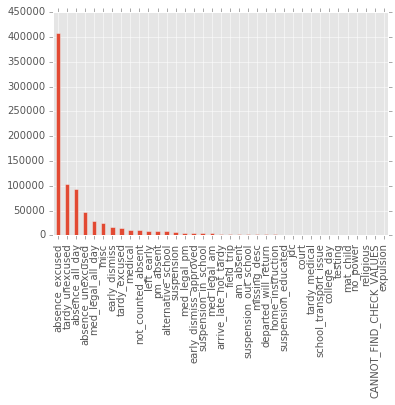

time: 1.46 s


In [5]:
absences['absence_desc'].value_counts().plot(kind='bar')

with postgres_pgconnection_generator() as connection:
    withdraw_reason = get_column(connection,['withdraw_reason'],'wrk_tracking_students')

withdraws = withdraw_reason[pd.notnull(withdraw_reason['withdraw_reason'])]
dropouts = withdraws[withdraws['withdraw_reason'].str.contains('dropout')]
transfers = withdraws[withdraws['withdraw_reason'].str.contains('transfer')]
graduates = withdraws[withdraws['withdraw_reason'].str.contains('grad')]
print("{0} grads, {1} dropouts, {2} transfers".format(len(graduates.index), len(dropouts.index),len(transfers.index)))


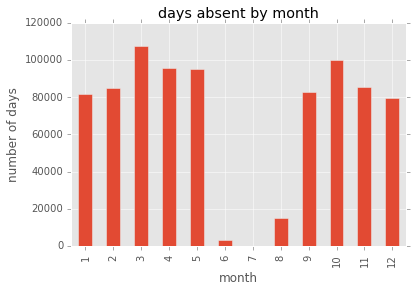

time: 788 ms


In [5]:
absences['month'].value_counts().reindex(range(1,13)).plot(kind='bar')
plt.title('days absent by month')
plt.ylabel('number of days')
plt.xlabel('month')
plt.savefig('month_hist.png', bbox_inches='tight')

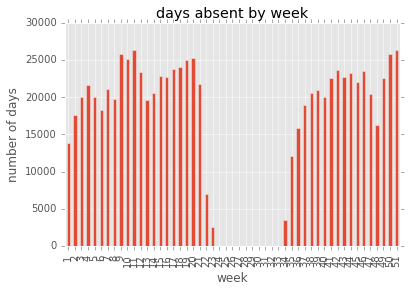

time: 2.05 s


In [6]:
absences['week'].value_counts().reindex(range(1,52)).plot(kind='bar')
plt.title('days absent by week')
plt.ylabel('number of days')
plt.xlabel('week')
plt.savefig('week_hist.png', bbox_inches='tight')

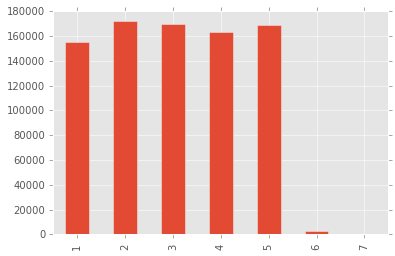

time: 441 ms


In [7]:
absences['weekday'].value_counts().reindex(range(1,8)).plot(kind='bar')

In [34]:
d1 = datetime.date(2000,9,30)
d2 = datetime.date(2000,10,3)

print(d1.weekday(), d2.weekday(), (d2-d1).days)


5 1 3
time: 2.86 ms


In [164]:
# should add singe absence counts as well

# def all_consecutive_absences(absences, date_range=None):
#     """
#     Returns the all instances of multiple consecutive absences/tardies
#     :param dataframe absences: dataframe with student_lookup and date columns
#     :param pair date_range: pair of dates, (lower_bound, upper_bound)
#     :rtype: list of ints
#     """
#     if date_range:
#         absences = absences[(absences['date']>date_range[0]) & (absences['date']<date_range[1])]
#     absent_dates = absences.sort_values(['student_lookup','date'])['date']
#     delta = absent_dates[1:].reset_index()- absent_dates[:-1].reset_index()
#     # should really exclude edge cases - between student blocks
#     delta_list = [d.days for d in delta['date']]
#     delta_counts = [sum(1 for i in g)+1 for d, g in groupby(delta_list) if (d==1)] 
#     delta_counts += [1 for d, g in groupby(delta_list) if (d!=1)]
#     return delta_counts
     
def next_day(row):
    """
    Returns 1 if the given pair of days is consecutive, else 0
    row of the form  [student_lookup1,date1, student_lookup2, date2]
    """
    if row['s1']==row['s2']:
        if (row['d2']- row['d1']).days == 1:
            return 1
        elif row['d2'].weekday()==1 and row['d1'].weekday() > 4 and (row['d2']-row['d1']).days < 4:
            return 1
        else:
            return 0
        
#test cases more thoroughly


time: 7.12 ms


In [174]:
def all_consecutive_absences(absences, date_range=None):
    """
    Returns the all instances of multiple consecutive absences/tardies
    :param dataframe absences: dataframe with student_lookup and date columns
    :param pair date_range: pair of dates, (lower_bound, upper_bound)
    :rtype: list of ints
    """
    if date_range:
        absences = absences[(absences['date']>date_range[0]) & (absences['date']<date_range[1])]
    absent_dates = absences.sort_values(['student_lookup','date'])[['student_lookup','date']]
    date_pairs = pd.DataFrame()
    date_pairs['s1'] = absent_dates[:-1]['student_lookup'].values
    date_pairs['s2'] = absent_dates[1:]['student_lookup'].values
    date_pairs['d1'] = absent_dates[:-1]['date'].values
    date_pairs['d2'] = absent_dates[1:]['date'].values
    delta = date_pairs.apply(next_day, axis=1)
    return [sum(1 for i in g)+1 for d, g in groupby(delta) if (d==1)] # check this logic

def consecutive_absences(absences, student_lookup, date_range=None):
    """
    Returns instances of multiple consecutive absences/tardies for a 
    particular student
    :param dataframe absences: dataframe with student_lookup and date columns
    :param int student_lookup:
    :param pair date_range: pair of dates, (lower_bound, upper_bound)
    :rtype: list of ints
    """
    if date_range:
        absences = absences[(absences['date']>date_range[0]) & (absences['date']<date_range[1])]
    student = absences[absences['student_lookup']==student_lookup]
    student = student.sort_values('date')['date']
    delta = student[1:].reset_index()- student[:-1].reset_index()
    delta_list = [d.days for d in delta['date']]
    return [sum(1 for i in g)+1 for d, g in groupby(delta_list) if (d==1)]

time: 30.1 ms


(array([  0.00000000e+00,   7.73870000e+04,   2.25350000e+04,
          9.34300000e+03,   8.70200000e+03,   3.20000000e+01,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 9 Patch objects>)

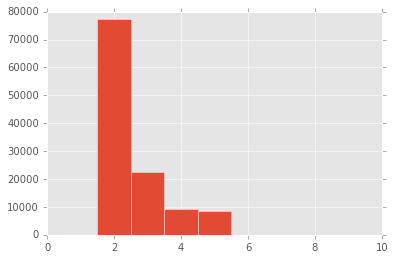

time: 2min 4s


In [166]:
res = all_consecutive_absences(absences)
plt.hist(res, range(1,int(max(res))+3),align='left')

In [179]:
sum(1 for r in res if r > 5)

33

time: 6.96 ms


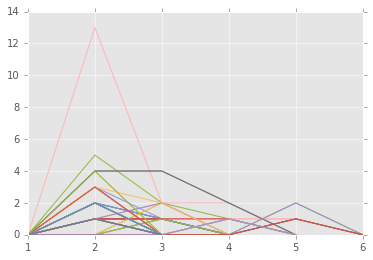

time: 15.1 s


In [9]:
unique_SL = absences.loc[~absences['student_lookup'].duplicated()]['student_lookup']
min_date = datetime.date(2015,8,1)
max_date = datetime.date(2016,6,15)
date_range = (min_date,max_date)
for s in unique_SL[:100]:
    consecutive_counts = consecutive_absences(absences,s,date_range)
    if consecutive_counts:
        [y,x] = np.histogram(consecutive_counts, range(1,max(consecutive_counts)+3))
        plt.plot(x[:-1],y)
    

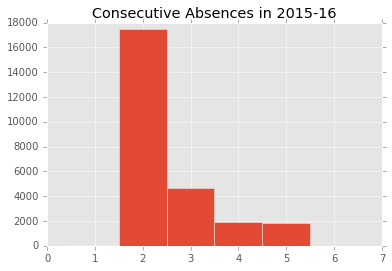

time: 28.8 s


In [175]:
min_date = datetime.date(2015,8,1)
max_date = datetime.date(2016,7,1)
date_range = (min_date,max_date)
consecutive_counts = all_consecutive_absences(absences,date_range ) 
plt.hist(consecutive_counts, range(1,max(consecutive_counts)+3),align='left')
plt.title('Consecutive Absences in 2015-16')
plt.savefig('consecutive_abs_15_16.png', bbox_inches='tight')

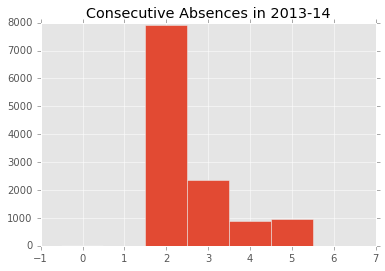

time: 26.8 s


In [176]:
min_date = datetime.date(2013,8,1)
max_date = datetime.date(2014,7,1)
date_range = (min_date,max_date)
consecutive_counts = all_consecutive_absences(absences,date_range)
plt.hist(consecutive_counts, range(max(consecutive_counts)+3),align='left')
plt.title('Consecutive Absences in 2013-14')
plt.savefig('consecutive_abs_13_14.png', bbox_inches='tight')

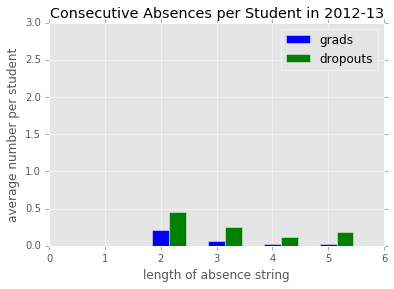

time: 17.6 s


In [177]:
min_date = datetime.date(2012,8,1)
max_date = datetime.date(2013,6,15)
date_range = (min_date,max_date)

transfer_absences = absences[absences['student_lookup'].isin(transfers['student_lookup'])]
grad_absences = absences[absences['student_lookup'].isin(graduates['student_lookup'])]
dropout_absences = absences[absences['student_lookup'].isin(dropouts['student_lookup'])]

consecutive_counts_transfers = all_consecutive_absences(transfer_absences,date_range)
consecutive_counts_grads = all_consecutive_absences(grad_absences,date_range)
consecutive_counts_dropouts = all_consecutive_absences(dropout_absences,date_range)

[y_trans,x_trans] = np.histogram(consecutive_counts_transfers, range(1,max(consecutive_counts_transfers)+2))
[y_grad,x_grad] = np.histogram(consecutive_counts_grads, range(1,max(consecutive_counts_grads)+2))
[y_drop,x_drop] = np.histogram(consecutive_counts_dropouts, range(1,max(consecutive_counts_dropouts)+2))

#y_grad[0] = len(grad_absences) - np.sum(consecutive_counts_grads)
#y_drop[0] = len(dropout_absences) - np.sum(consecutive_counts_dropouts)

#plt.bar(x_trans[:-1]-.3,np.divide(y_trans,len(transfers.index)),align='center',color = 'r',width=.3)
plt.bar(x_grad[:-1],np.divide(y_grad,len(graduates.index)),align='center', color = 'b',width=.3)
plt.bar(x_drop[:-1]+.3,np.divide(y_drop,len(dropouts.index)),align='center', color = 'g',width=.3)

plt.legend(['grads','dropouts'])
plt.ylim([0,3])
plt.title('Consecutive Absences per Student in 2012-13')
plt.xlabel('length of absence string')
plt.ylabel('average number per student')
plt.savefig('consecutive_abs_12_13_divided.png', bbox_inches='tight')

# only considering students absent at least once

min =  0.0 , max =  87.5
141 out of 587 (24.0%) differ by > 5 days


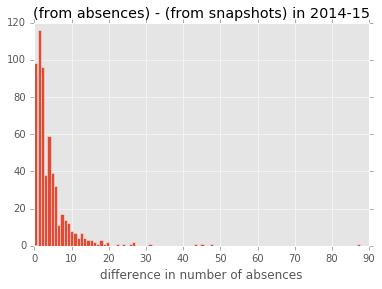

time: 1.87 s


In [13]:
# differences between aggregate data in all_snapshots and all_absences data
year = 14
with postgres_pgconnection_generator() as connection:
    num_absences = pd.read_sql(""" 
    select temp_absences.student_lookup, from_absences, from_snapshots from 
        (select student_lookup, count(date) as from_absences
            from clean.all_absences
                where (date > to_date('20{0}-08-01','YYYY-MM-DD') 
                      and date < to_date('20{1}-06-15','YYYY-MM-DD')  
                      --and absence_desc not like '%excused%' 
                      and school = 'RVHS')
                group by student_lookup) as temp_absences
    inner join (select student_lookup, days_absent as from_snapshots 
            from clean.all_snapshots 
                  where (school_year = 20{0} 
                  and school_code = 'RVHS') ) as temp_snapshots
    on temp_absences.student_lookup = temp_snapshots.student_lookup;
    """.format(year,year+1), connection)
        
num_absences.head(10)
table_diff = num_absences.from_absences - num_absences.from_snapshots;
table_diff.hist(bins=100)
plt.title('(from absences) - (from snapshots) in 20{0}-{1}'.format(year,year+1))
plt.xlabel('difference in number of absences')
plt.savefig('difference_hist.png', bbox_inches='tight')
print('min = ', min(table_diff), ', max = ', max(table_diff))
num_absences[['from_absences','from_snapshots']].describe()
num_over = sum(np.abs(table_diff) > 5)
total = len(table_diff)
print('{0} out of {1} ({2:0.1f}%) differ by > 5 days'.format(num_over, total, num_over/total*100))



min =  -39.0 , max =  37.5
152 out of 315 (48.3%) differ by > 5 days


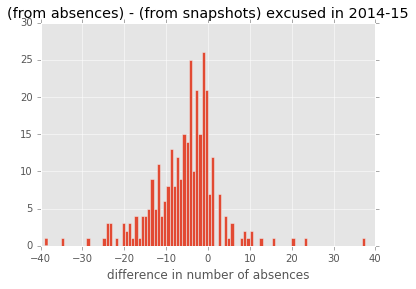

time: 1.79 s


In [14]:
# differences between aggregate data in all_snapshots and all_absences data - excused
year = 14
with postgres_pgconnection_generator() as connection:
    num_absences = pd.read_sql(""" 
    select temp_absences.student_lookup, from_absences, from_snapshots from 
        (select student_lookup, count(date) as from_absences
            from clean.all_absences
                where (date > to_date('20{0}-08-01','YYYY-MM-DD') 
                      and date < to_date('20{1}-06-15','YYYY-MM-DD')  
                      and absence_desc not like '%excused%' 
                      and school = 'RVHS')
                group by student_lookup) as temp_absences
    inner join (select student_lookup, days_absent as from_snapshots 
            from clean.all_snapshots 
                  where (school_year = 20{0} 
                  and school_code = 'RVHS') ) as temp_snapshots
    on temp_absences.student_lookup = temp_snapshots.student_lookup;
    """.format(year,year+1), connection)
        
num_absences.head(10)
table_diff = num_absences.from_absences - num_absences.from_snapshots;
table_diff.hist(bins=100)
plt.title('(from absences) - (from snapshots) excused in 20{0}-{1}'.format(year,year+1))
plt.xlabel('difference in number of absences')
plt.savefig('difference_hist_excused.png', bbox_inches='tight')
print('min = ', min(table_diff), ', max = ', max(table_diff))
num_absences[['from_absences','from_snapshots']].describe()
num_over = sum(np.abs(table_diff) > 5)
total = len(table_diff)
print('{0} out of {1} ({2:0.1f}%) differ by > 5 days'.format(num_over, total, num_over/total*100))

In [15]:
with postgres_pgconnection_generator() as connection:
    num_absences = pd.read_sql(""" 
    select school, sum(case when from_absences - from_snapshots > 5 then 1 else 0 end) as off_by_5_plus,
        count(*) as total, sum(case when from_absences - from_snapshots > 5 then 1 else 0 end)::float/count(*)*100 as percentage
    from(select temp_absences.student_lookup, from_absences, from_snapshots , school from 
            (select student_lookup, count(date) as from_absences, school
                from clean.all_absences
                    where (date > to_date('20{0}-08-01','YYYY-MM-DD') 
                          and date < to_date('20{1}-07-01','YYYY-MM-DD')  )
                          group by student_lookup, school) as temp_absences
        inner join (select student_lookup, days_absent as from_snapshots 
                from clean.all_snapshots 
                      where (school_year = 20{0}) ) as temp_snapshots
        on temp_absences.student_lookup = temp_snapshots.student_lookup ) as temp
    group by school;
    """.format(year,year+1), connection)
    
num_absences

,school,off_by_5_plus,total,percentage
0,RIWE,99,411,24.087591
1,RVHS,155,606,25.577558
2,TVEF,76,345,22.028986
3,WMEH,71,183,38.797814
4,RCON,20,384,5.208333
5,within the two hour window,1,89,1.123596
6,FRMS,75,299,25.083612
7,MAES,282,1095,25.753425
8,MAMS,213,564,37.765957
9,WMHS,205,472,43.432203


time: 832 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fadf972f4a8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fadf8fc9358>]], dtype=object)

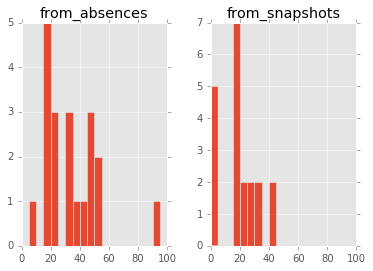

time: 1.62 s


In [21]:
# attendance data and withdrawal codes
year = 14
with postgres_pgconnection_generator() as connection:
    num_absences = pd.read_sql(""" 
    select temp_absences.student_lookup, from_absences, from_snapshots from 
        (select student_lookup, count(date) as from_absences
            from clean.all_absences
                where (date > to_date('20{0}-08-01','YYYY-MM-DD') 
                      and date < to_date('20{1}-06-15','YYYY-MM-DD'))
                group by student_lookup) as temp_absences
    inner join (select student_lookup, days_absent as from_snapshots 
                    from clean.all_snapshots 
                      where (school_year = 20{0}) ) as temp_snapshots
    inner join (select student_lookup, withdraw_reason from clean.wrk_tracking_students 
                    where withdraw_reason = 'dropout - attendence') as temp_withdraw
                on temp_withdraw.student_lookup = temp_snapshots.student_lookup
    on temp_absences.student_lookup = temp_snapshots.student_lookup;
    """.format(year,year+1), connection)

num_absences[['from_absences', 'from_snapshots']].describe()
num_absences[['from_absences', 'from_snapshots']].hist(bins=range(0,100,5))